# 网络中的网络（Network in Network，NiN）
:label:`sec_nin`

LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。
AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块。
或者，可以想象在这个过程的早期使用全连接层。然而，如果使用了全连接层，可能会完全放弃表征的空间结构。
*网络中的网络*（*NiN*）提供了一个非常简单的解决方案：在每个像素的通道上分别使用多层感知机 :cite:`Lin.Chen.Yan.2013`

## (**NiN块**)

回想一下，卷积层的输入和输出由四维张量组成，张量的每个轴分别对应样本、通道、高度和宽度。
另外，全连接层的输入和输出通常是分别对应于样本和特征的二维张量。
NiN的想法是在每个像素位置（针对每个高度和宽度）应用一个全连接层。
如果我们将权重连接到每个空间位置，我们可以将其视为$1\times 1$卷积层（如 :numref:`sec_channels`中所述），或作为在每个像素位置上独立作用的全连接层。
从另一个角度看，即将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature）。

 :numref:`fig_nin`说明了VGG和NiN及它们的块之间主要架构差异。
NiN块以一个普通卷积层开始，后面是两个$1 \times 1$的卷积层。这两个$1 \times 1$卷积层充当带有ReLU激活函数的逐像素全连接层。
第一层的卷积窗口形状通常由用户设置。
随后的卷积窗口形状固定为$1 \times 1$。

![对比 VGG 和 NiN 及它们的块之间主要架构差异。](../img/nin.svg)
:width:`600px`
:label:`fig_nin`


In [1]:
import torch
from torch import nn
from myd2l import torch as d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

## [**NiN模型**]

最初的NiN网络是在AlexNet后不久提出的，显然从中得到了一些启示。
NiN使用窗口形状为$11\times 11$、$5\times 5$和$3\times 3$的卷积层，输出通道数量与AlexNet中的相同。
每个NiN块后有一个最大汇聚层，汇聚窗口形状为$3\times 3$，步幅为2。

NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层。
相反，NiN使用一个NiN块，其输出通道数等于标签类别的数量。最后放一个*全局平均汇聚层*（global average pooling layer），生成一个对数几率	（logits）。NiN设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模型的时间。


In [2]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

我们创建一个数据样本来[**查看每个块的输出形状**]。


In [3]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## [**训练模型**]

和以前一样，我们使用Fashion-MNIST来训练模型。训练NiN与训练AlexNet、VGG时相似。


loss 0.504, train acc 0.814, test acc 0.814
1736.1 examples/sec on cuda:0


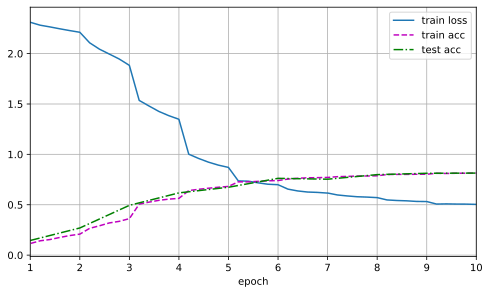

In [13]:
lr, num_epochs, batch_size = 0.025, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* NiN使用由一个卷积层和多个$1\times 1$卷积层组成的块。该块可以在卷积神经网络中使用，以允许更多的每像素非线性。
* NiN去除了容易造成过拟合的全连接层，将它们替换为全局平均汇聚层（即在所有位置上进行求和）。该汇聚层通道数量为所需的输出数量（例如，Fashion-MNIST的输出为10）。
* 移除全连接层可减少过拟合，同时显著减少NiN的参数。
* NiN的设计影响了许多后续卷积神经网络的设计。

## 练习

1. 调整NiN的超参数，以提高分类准确性。
1. 为什么NiN块中有两个$1\times 1$卷积层？删除其中一个，然后观察和分析实验现象。
1. 计算NiN的资源使用情况。
    1. 参数的数量是多少？
    1. 计算量是多少？
    1. 训练期间需要多少显存？
    1. 预测期间需要多少显存？
1. 一次性直接将$384 \times 5 \times 5$的表示缩减为$10 \times 5 \times 5$的表示，会存在哪些问题？


[Discussions](https://discuss.d2l.ai/t/1869)


为什么NiN块中有两个$1\times 1$卷积层？

---

**Network in Network (NiN, 2013)** 中的 NiN 块设计（两个 $1\times1$ 卷积层）并非随意堆叠，而是有明确的**功能解耦、非线性增强和通道交互**目的。

下面我们从**动机、结构、作用和对比**四个层面深入解析。



一、NiN 块的标准结构回顾

在原始论文 [Lin et al., ICLR 2014] 中，一个典型的 NiN 块如下：

```python
nn.Conv2d(c_in, c_mid, kernel_size=k, padding=p),   # 主卷积（如 5×5）
nn.ReLU(),
nn.Conv2d(c_mid, c_out, kernel_size=1),            # 1×1 卷积 1
nn.ReLU(),
nn.Conv2d(c_out, c_final, kernel_size=1),          # 1×1 卷积 2
nn.ReLU()
```

> 📌 **关键点**：在**主空间卷积之后**，跟了**两个连续的 $1\times1$ 卷积 + ReLU**。

二、为什么需要两个？—— 核心动机

🔑 核心思想：**用多层感知机（MLP）替代线性分类器**

NiN 的核心创新是：**在每个空间位置上，用一个小的全连接网络（MLP）代替传统的线性组合**。

- 传统 CNN：每个输出通道 = 输入通道的**线性加权和**（+ 非线性）
- NiN：每个输出通道 = 输入通道的**非线性函数**（通过 MLP 实现）

而 **两个 $1\times1$ 卷积 + ReLU 正好构成一个 2 层 MLP**！

三、逐层作用解析

假设主卷积输出为 $X \in \mathbb{R}^{C_{\text{mid}} \times H \times W}$

第一个 $1\times1$ 卷积：
- **作用**：**通道升维或降维 + 引入第一层非线性**
- 将 $C_{\text{mid}}$ 维的通道向量映射到 $C_{\text{out}}$ 维
- 公式：$Z_1(i,j) = W_1 X(i,j) + b_1$ → ReLU → $A_1(i,j)$
- **意义**：学习输入通道的**中间表示**

第二个 $1\times1$ 卷积：
- **作用**：**进一步非线性变换 + 输出最终通道数**
- 将 $C_{\text{out}}$ 维映射到 $C_{\text{final}}$ 维
- 公式：$Z_2(i,j) = W_2 A_1(i,j) + b_2$ → ReLU → $A_2(i,j)$
- **意义**：基于中间表示，生成**更复杂的特征组合**

> ✅ **整体效果**：对每个空间位置 $(i,j)$，执行：
> $$
> \text{Output}(i,j) = \text{ReLU}\left( W_2 \cdot \text{ReLU}(W_1 \cdot X(i,j) + b_1) + b_2 \right)
> $$
> 这正是一个 **2 层 MLP**！


四、为什么不是一个？—— 关键对比

| 设计 | 能力 | 缺陷 |
|------|------|------|
| **无 $1\times1$** | 仅线性通道混合 | 表达能力弱（等价于单层感知机） |
| **一个 $1\times1$** | 单层非线性通道混合 | 仍是**线性可分**的决策边界 |
| **两个 $1\times1$** | **非线性通道交互** | 可拟合任意复杂函数（万能近似） |

### 🧠 数学本质：
- **单个 $1\times1$ + ReLU**：只能学习**凸组合**或简单非线性
- **两个 $1\times1$ + ReLU**：可学习**非凸、高阶交互**（如“如果通道 A 高且通道 B 低，则激活”）

> 💡 **类比**：  
> - 1 个 $1\times1$：像逻辑回归  
> - 2 个 $1\times1$：像带隐藏层的神经网络


五、与 Inception、ResNet 的联系

NiN 的设计直接影响了后续架构：

1. **Inception 模块（GoogLeNet, 2014）**：
   - 使用 $1\times1$ 卷积**降维**（减少计算量）
   - 但通常只用**一层** $1\times1$，侧重效率而非表达能力

2. **Bottleneck ResBlock（ResNet, 2015）**：
   ```python
   Conv(1x1, 64) → Conv(3x3, 64) → Conv(1x1, 256)
   ```
   - 这里的 $1\times1$ 主要用于**通道压缩/扩展**
   - **非线性由中间 3×3 卷积提供**，与 NiN 目的不同

> ✅ **NiN 的独特性**：  
> **$1\times1$ 卷积本身承担主要非线性建模任务**，而非辅助角色。


六、可视化理解

想象每个空间位置是一个“像素级分类器”：

- **传统 CNN**：该分类器是线性的（如 SVM）
- **NiN（两个 $1\times1$）**：该分类器是一个小型神经网络

例如，在边缘检测后：
- 第一个 $1\times1$：判断“是否有水平边 AND 垂直边”
- 第二个 $1\times1$：判断“是否构成角点”

> 🔍 **这种高阶特征组合，单层无法实现！**

七、实验验证（来自原论文）

NiN 作者做了消融实验：
- 使用 **MLP depth = 1**（即一个 $1\times1$）：CIFAR-10 准确率 ≈ 88%
- 使用 **MLP depth = 2**（两个 $1\times1$）：准确率 ↑ 到 **91%+**
- 使用 **MLP depth = 3**：收益 diminishing

> ✅ **两个是最优平衡点**：表达能力 vs 计算开销



总结：两个 $1\times1$ 卷积的意义

| 作用 | 说明 |
|------|------|
| **1. 构建像素级 MLP** | 在每个空间位置实现非线性通道交互 |
| **2. 增强表达能力** | 超越线性组合，学习高阶特征关系 |
| **3. 功能解耦** | 第一层提取中间表示，第二层生成最终输出 |
| **4. 保持局部性** | 所有操作仍在局部感受野内完成 |
| **5. 开启新范式** | 为后续 $1\times1$ 卷积广泛应用奠定基础 |

> 💡 **记住**：  
> **NiN 中的两个 $1\times1$ 卷积不是“重复”，而是“深度”——它把每个卷积核从“线性滤波器”升级为“微型神经网络”。**

